In [27]:
import pandas as pd
import numpy as np
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import keras_tuner as kt


In [39]:
#---Preparing the Data---#


def plotmodel(model,name,plt):
    
    print(model.history.keys())
    
    # summarize history for accuracy
    plt.title(name+' model accuracy for baseline')
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.title(name+' model loss  for baseline')
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for precision
    plt.title(name+' model precision')
    plt.plot(model.history['precision'])
    plt.plot(model.history['val_precision'])
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
          
    # summarize history for recall
    plt.title(name+' model recall  for baseline')
    plt.plot(model.history['recall'])
    plt.plot(model.history['val_recall'])
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for auc
    plt.title(name+' model auc  for baseline')
    plt.plot(model.history['auc'])
    plt.plot(model.history['val_auc'])
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    


def printMetrics(model,name):
    print(name)
    print(name+" Model loss: %.2f%% (%.2f%%)" % (np.mean(model.history['loss'])*100, np.std(model.history['loss'])*100))
    print(name+" Model accuracy: %.2f%% (%.2f%%)" % (np.mean(model.history['accuracy'])*100, np.std(model.history['accuracy'])*100))
    print(name+" Model precision: %.2f%% (%.2f%%)" % (np.mean(model.history['precision'])*100, np.std(model.history['precision'])*100))
    print(name+" Model recall: %.2f%% (%.2f%%)" % (np.mean(model.history['recall'])*100, np.std(model.history['recall'])*100))
    print(name+" Model auc: %.2f%% (%.2f%%)" % (np.mean(model.history['auc'])*100, np.std(model.history['auc'])*100))
    print(name+" Model val_loss: %.2f%% (%.2f%%)" % (np.mean(model.history['val_loss'])*100, np.std(model.history['val_loss'])*100))
    print(name+" Model val_accuracy: %.2f%% (%.2f%%)" % (np.mean(model.history['val_accuracy'])*100, np.std(model.history['val_accuracy'])*100))
    print(name+" Model val_precision: %.2f%% (%.2f%%)" % (np.mean(model.history['val_precision'])*100, np.std(model.history['val_precision'])*100))
    print(name+" Model val_recall: %.2f%% (%.2f%%)" % (np.mean(model.history['val_recall'])*100, np.std(model.history['val_recall'])*100))
    print(name+" Model val_auc: %.2f%% (%.2f%%)" % (np.mean(model.history['val_auc'])*100, np.std(model.history['val_auc'])*100))

In [136]:
#specific plot just for the hypermodel due to scaling issues
def plotHyperModel(model,name,plt):
    
    print(model.history.keys())
    
    ax = plt.gca()
    ax.set_ylim([0.625,0.87])
    # summarize history for accuracy
    plt.title(name+' model accuracy for baseline')
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    ax = plt.gca()
    ax.set_ylim([0.1,0.45])
    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss  for baseline')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    ax = plt.gca()
    ax.set_ylim([0.60, 0.85])
    # summarize history for precision
    plt.title(name+' model precision')
    plt.plot(model.history['precision'])
    plt.plot(model.history['val_precision'])
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    ax = plt.gca()
    ax.set_ylim([0.78,0.95])
    # summarize history for recall
    plt.title(name+' model recall  for baseline')
    plt.plot(model.history['recall'])
    plt.plot(model.history['val_recall'])
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    ax = plt.gca()
    ax.set_ylim([0.70,0.92])
    # summarize history for auc
    plt.title(name+' model auc  for baseline')
    plt.plot(model.history['auc'])
    plt.plot(model.history['val_auc'])
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [29]:
#---Preparing the Data---#

# Header = 0 to signify that the first row is the header
df = pd.read_csv("new_binary.csv", header = 0)

# Remove first unwanted column
df = df.iloc[: , 1:]
# Make sure each address is its own unique ID
df = df.assign(id=(df['address']).astype('category').cat.codes)
# Zero index year, normalize it for matrix calculations
df = df.assign(year=(df['year']).astype('category').cat.codes)
df = df.drop(['address'], axis=1)
#Separate X, Y
X = df.drop(['label'], axis = 1).astype(float)
Y = df.label.values

#normalizing
scaler = MinMaxScaler().fit(X)
x_scaled = scaler.transform(X)
n_features = x_scaled.shape[1]
print(n_features)

9


In [30]:
#---Baseline Model---#

model = Sequential()
# Add more layers, probably won't change from Sequential though
model.add(Dense(4, input_dim=n_features, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# Add more metrics, try diff losses, optimizers, etc.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 40        
                                                                 
 dense_13 (Dense)            (None, 2)                 10        
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [31]:
baseline_model = model.fit(x_scaled, Y, validation_split=0.3, epochs=100, batch_size=32, verbose=2)


Epoch 1/100
875/875 - 1s - loss: 0.6802 - accuracy: 0.5759 - precision: 0.5789 - recall: 0.5592 - auc: 0.5962 - val_loss: 0.6722 - val_accuracy: 0.5981 - val_precision: 0.5842 - val_recall: 0.6807 - val_auc: 0.6094 - 1s/epoch - 2ms/step
Epoch 2/100
875/875 - 1s - loss: 0.6693 - accuracy: 0.5941 - precision: 0.5831 - recall: 0.6626 - auc: 0.6091 - val_loss: 0.6627 - val_accuracy: 0.6027 - val_precision: 0.5857 - val_recall: 0.7015 - val_auc: 0.6122 - 643ms/epoch - 735us/step
Epoch 3/100
875/875 - 1s - loss: 0.6603 - accuracy: 0.6028 - precision: 0.5841 - recall: 0.7168 - auc: 0.6065 - val_loss: 0.6537 - val_accuracy: 0.6032 - val_precision: 0.5841 - val_recall: 0.7162 - val_auc: 0.6063 - 640ms/epoch - 731us/step
Epoch 4/100
875/875 - 1s - loss: 0.6493 - accuracy: 0.6119 - precision: 0.5855 - recall: 0.7690 - auc: 0.6091 - val_loss: 0.6406 - val_accuracy: 0.6241 - val_precision: 0.5905 - val_recall: 0.8093 - val_auc: 0.6091 - 672ms/epoch - 768us/step
Epoch 5/100
875/875 - 1s - loss: 0.63

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


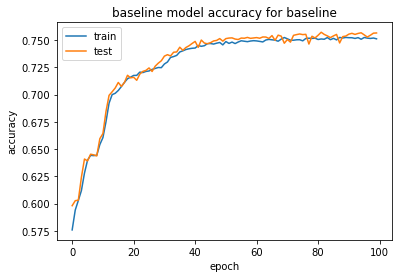

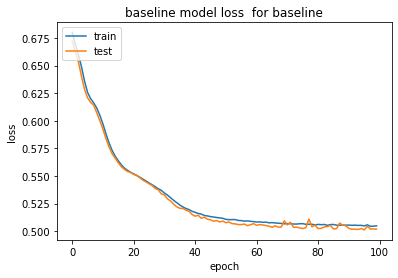

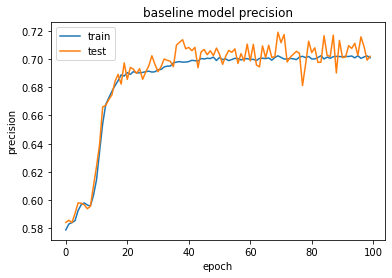

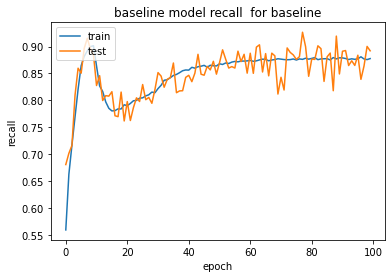

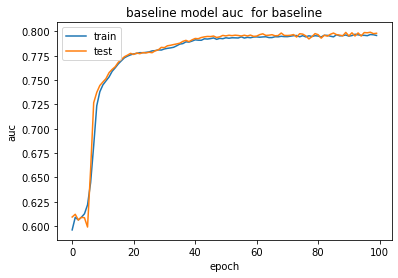

In [32]:
plotmodel(baseline_model,'baseline',plt)


In [40]:
printMetrics(baseline_model,'baseline')

baseline
baseline Model loss: 53.26% (4.13%)
baseline Model accuracy: 72.79% (3.95%)
baseline Model precision: 68.47% (3.36%)
baseline Model recall: 84.83% (4.91%)
baseline Model auc: 77.39% (4.71%)
baseline Model val_loss: 53.00% (4.04%)
baseline Model val_accuracy: 73.09% (3.83%)
baseline Model val_precision: 68.83% (3.45%)
baseline Model val_recall: 84.85% (4.51%)
baseline Model val_auc: 77.59% (4.66%)


In [62]:
#---Feature Selection Model: Select K Best---#
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(x_scaled,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print 6 best features


    Specs       Score
5  looped  102.428637
0    year   67.571401
8      id   60.946725
2  length   21.263435
4   count   19.010799
7  income    8.698478


In [63]:
k_best_X = df[['looped','year','id','length','count','income']]
scaler = MinMaxScaler().fit(k_best_X)
k_best_x_scaled = scaler.transform(k_best_X)
n_features = k_best_x_scaled.shape[1]

#BASELINE MODEL W/ FEATURE SELECTION
model = Sequential()
# Add more layers, probably won't change from Sequential though
model.add(Dense(4, input_dim=n_features, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# Add more metrics, try diff losses, optimizers, etc.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 4)                 28        
                                                                 
 dense_31 (Dense)            (None, 2)                 10        
                                                                 
 dense_32 (Dense)            (None, 1)                 3         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [64]:
select6KBestModel = model.fit(k_best_x_scaled, Y, validation_split=0.3, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
875/875 - 1s - loss: 0.6900 - accuracy: 0.5188 - precision: 0.5176 - recall: 0.5636 - auc: 0.5406 - val_loss: 0.6854 - val_accuracy: 0.5305 - val_precision: 0.5238 - val_recall: 0.6708 - val_auc: 0.5491 - 1s/epoch - 2ms/step
Epoch 2/100
875/875 - 1s - loss: 0.6793 - accuracy: 0.5499 - precision: 0.5363 - recall: 0.7428 - auc: 0.5694 - val_loss: 0.6718 - val_accuracy: 0.5493 - val_precision: 0.5357 - val_recall: 0.7395 - val_auc: 0.5694 - 659ms/epoch - 753us/step
Epoch 3/100
875/875 - 1s - loss: 0.6660 - accuracy: 0.5716 - precision: 0.5483 - recall: 0.8172 - auc: 0.5874 - val_loss: 0.6595 - val_accuracy: 0.5938 - val_precision: 0.5591 - val_recall: 0.8883 - val_auc: 0.5961 - 665ms/epoch - 760us/step
Epoch 4/100
875/875 - 1s - loss: 0.6562 - accuracy: 0.5926 - precision: 0.5584 - recall: 0.8895 - auc: 0.6017 - val_loss: 0.6528 - val_accuracy: 0.5904 - val_precision: 0.5562 - val_recall: 0.8955 - val_auc: 0.6078 - 714ms/epoch - 816us/step
Epoch 5/100
875/875 - 1s - loss: 0.65

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


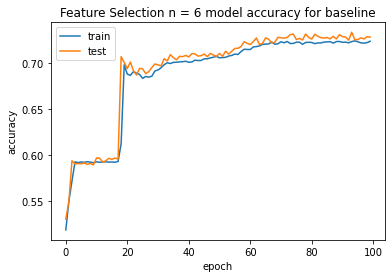

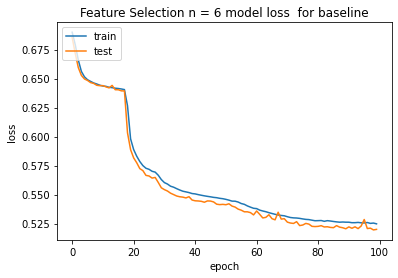

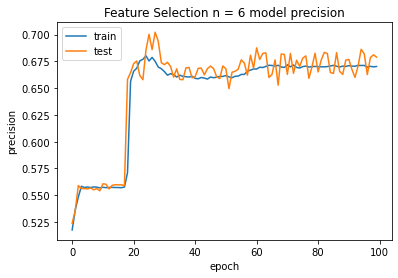

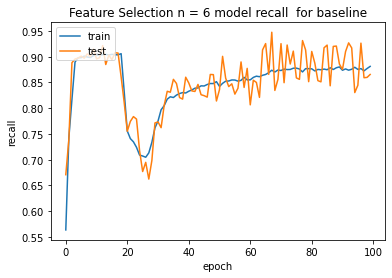

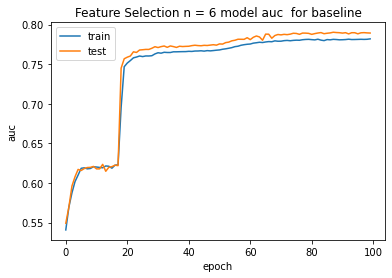

In [65]:
plotmodel(select6KBestModel,'Feature Selection n = 6',plt)


In [67]:
printMetrics(select6KBestModel,'Feature Selection n = 6')

Feature Selection n = 6
Feature Selection n = 6 Model loss: 56.30% (4.50%)
Feature Selection n = 6 Model accuracy: 68.70% (5.08%)
Feature Selection n = 6 Model precision: 64.59% (4.48%)
Feature Selection n = 6 Model recall: 84.70% (5.72%)
Feature Selection n = 6 Model auc: 74.24% (6.39%)
Feature Selection n = 6 Model val_loss: 55.85% (4.56%)
Feature Selection n = 6 Model val_accuracy: 69.26% (5.12%)
Feature Selection n = 6 Model val_precision: 65.05% (4.60%)
Feature Selection n = 6 Model val_recall: 85.26% (6.11%)
Feature Selection n = 6 Model val_auc: 74.93% (6.61%)


[0.29312426 0.15378869 0.04955521 0.07720167 0.04639483 0.02972185
 0.07367032 0.1461434  0.13039977]


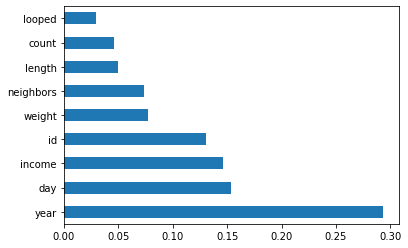

In [68]:
#---Feature Importance---#
treesClass = ExtraTreesClassifier()
treesClass.fit(x_scaled, Y)
print(treesClass.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(treesClass.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [53]:
feature_imp_X = df[['year','day','income','id','weight','neighbors']]
scaler = MinMaxScaler().fit(feature_imp_X)
feature_imp_x_scaled = scaler.transform(feature_imp_X)
n_features = feature_imp_x_scaled.shape[1]

In [69]:
#BASELINE MODEL W/ FEATURE IMPORTANCE N = 6
model = Sequential()
# Add more layers, probably won't change from Sequential though
model.add(Dense(4, input_dim=n_features, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# Add more metrics, try diff losses, optimizers, etc.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4)                 28        
                                                                 
 dense_34 (Dense)            (None, 2)                 10        
                                                                 
 dense_35 (Dense)            (None, 1)                 3         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [70]:
featureImportanceModel = model.fit(feature_imp_x_scaled, Y, validation_split=0.3, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
875/875 - 2s - loss: 0.6901 - accuracy: 0.5316 - precision: 0.5302 - recall: 0.5617 - auc: 0.5454 - val_loss: 0.6864 - val_accuracy: 0.5372 - val_precision: 0.5380 - val_recall: 0.5273 - val_auc: 0.5742 - 2s/epoch - 2ms/step
Epoch 2/100
875/875 - 1s - loss: 0.6823 - accuracy: 0.5556 - precision: 0.5492 - recall: 0.6258 - auc: 0.5957 - val_loss: 0.6766 - val_accuracy: 0.5753 - val_precision: 0.5636 - val_recall: 0.6678 - val_auc: 0.6184 - 643ms/epoch - 735us/step
Epoch 3/100
875/875 - 1s - loss: 0.6655 - accuracy: 0.6146 - precision: 0.6029 - recall: 0.6739 - auc: 0.6475 - val_loss: 0.6494 - val_accuracy: 0.6607 - val_precision: 0.6302 - val_recall: 0.7780 - val_auc: 0.6825 - 662ms/epoch - 757us/step
Epoch 4/100
875/875 - 1s - loss: 0.6300 - accuracy: 0.6558 - precision: 0.6337 - recall: 0.7397 - auc: 0.6998 - val_loss: 0.6078 - val_accuracy: 0.6804 - val_precision: 0.6475 - val_recall: 0.7922 - val_auc: 0.7240 - 674ms/epoch - 770us/step
Epoch 5/100
875/875 - 1s - loss: 0.59

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


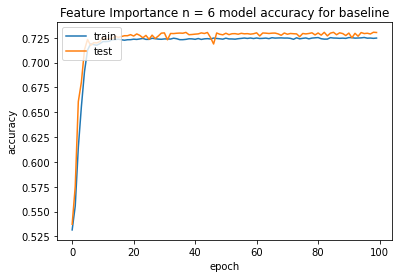

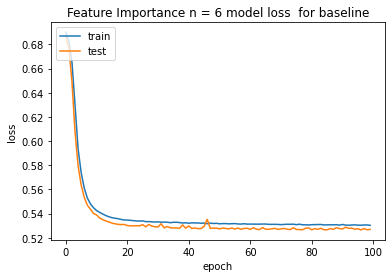

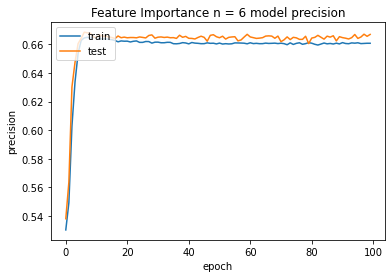

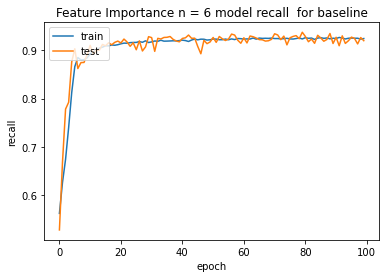

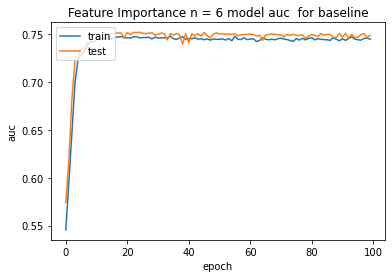

In [71]:
plotmodel(featureImportanceModel,'Feature Importance n = 6',plt)


In [72]:
printMetrics(featureImportanceModel,'Feature Importance n = 6')

Feature Importance n = 6
Feature Importance n = 6 Model loss: 53.96% (2.78%)
Feature Importance n = 6 Model accuracy: 71.80% (2.83%)
Feature Importance n = 6 Model precision: 65.79% (1.82%)
Feature Importance n = 6 Model recall: 90.65% (5.60%)
Feature Importance n = 6 Model auc: 73.98% (2.68%)
Feature Importance n = 6 Model val_loss: 53.53% (2.62%)
Feature Importance n = 6 Model val_accuracy: 72.31% (2.55%)
Feature Importance n = 6 Model val_precision: 66.22% (1.65%)
Feature Importance n = 6 Model val_recall: 90.86% (5.10%)
Feature Importance n = 6 Model val_auc: 74.46% (2.29%)


In [73]:
#FeatureImportance + High Increase in Neurons
model = Sequential()
model.add(Dense(70, input_dim=n_features, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 70)                490       
                                                                 
 dense_37 (Dense)            (None, 35)                2485      
                                                                 
 dense_38 (Dense)            (None, 4)                 144       
                                                                 
 dense_39 (Dense)            (None, 1)                 5         
                                                                 
Total params: 3,124
Trainable params: 3,124
Non-trainable params: 0
_________________________________________________________________


In [74]:
featureImportanceHighNeuronsModel = model.fit(feature_imp_x_scaled, Y, validation_split=0.3, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
875/875 - 2s - loss: 0.6387 - accuracy: 0.6179 - precision: 0.6115 - recall: 0.6487 - auc: 0.6744 - val_loss: 0.5930 - val_accuracy: 0.6919 - val_precision: 0.6300 - val_recall: 0.9298 - val_auc: 0.7408 - 2s/epoch - 2ms/step
Epoch 2/100
875/875 - 1s - loss: 0.5638 - accuracy: 0.7099 - precision: 0.6700 - recall: 0.8284 - auc: 0.7494 - val_loss: 0.5461 - val_accuracy: 0.7072 - val_precision: 0.6865 - val_recall: 0.7630 - val_auc: 0.7646 - 747ms/epoch - 854us/step
Epoch 3/100
875/875 - 1s - loss: 0.5277 - accuracy: 0.7280 - precision: 0.6776 - recall: 0.8708 - auc: 0.7951 - val_loss: 0.5041 - val_accuracy: 0.7366 - val_precision: 0.6857 - val_recall: 0.8737 - val_auc: 0.8251 - 755ms/epoch - 863us/step
Epoch 4/100
875/875 - 1s - loss: 0.4947 - accuracy: 0.7579 - precision: 0.7236 - recall: 0.8354 - auc: 0.8288 - val_loss: 0.4819 - val_accuracy: 0.7730 - val_precision: 0.7218 - val_recall: 0.8883 - val_auc: 0.8359 - 740ms/epoch - 846us/step
Epoch 5/100
875/875 - 1s - loss: 0.47

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


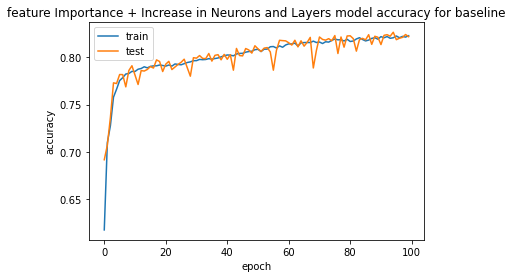

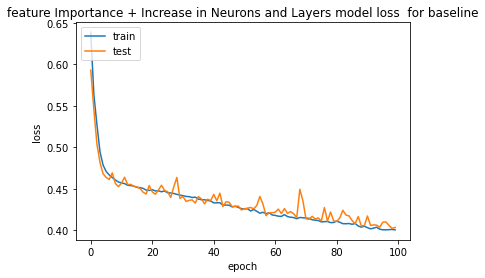

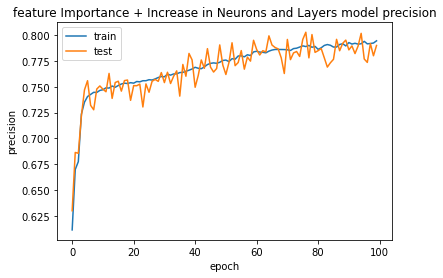

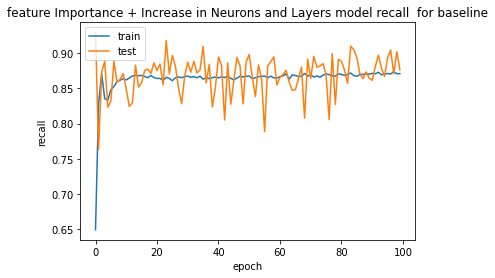

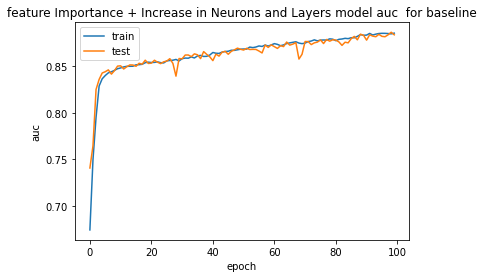

In [75]:
plotmodel(featureImportanceHighNeuronsModel,'feature Importance + Increase in Neurons and Layers',plt)


In [89]:
printMetrics(featureImportanceHighNeuronsModel,'Increased  Neurons & Layers')

Increased  Neurons & Layers
Increased  Neurons & Layers Model loss: 43.30% (3.32%)
Increased  Neurons & Layers Model accuracy: 80.16% (2.59%)
Increased  Neurons & Layers Model precision: 76.90% (2.68%)
Increased  Neurons & Layers Model recall: 86.35% (2.27%)
Increased  Neurons & Layers Model auc: 86.31% (2.67%)
Increased  Neurons & Layers Model val_loss: 43.51% (2.73%)
Increased  Neurons & Layers Model val_accuracy: 80.19% (2.16%)
Increased  Neurons & Layers Model val_precision: 76.73% (2.57%)
Increased  Neurons & Layers Model val_recall: 86.90% (2.78%)
Increased  Neurons & Layers Model val_auc: 86.32% (2.03%)


In [81]:
#--- Feature Importance + High Neurons + Dropout Layers

model = Sequential()
model.add(Dense(70, input_dim=n_features, activation='relu'))
model.add(Dropout(0.068))
model.add(Dense(35, activation='relu'))
model.add(Dropout(0.058))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 70)                490       
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_41 (Dense)            (None, 35)                2485      
                                                                 
 dropout_1 (Dropout)         (None, 35)                0         
                                                                 
 dense_42 (Dense)            (None, 4)                 144       
                                                                 
 dense_43 (Dense)            (None, 1)                 5         
                                                                 
Total params: 3,124
Trainable params: 3,124
Non-train

In [84]:
dropoutLayers_model = model.fit(feature_imp_x_scaled, Y, validation_split=0.3, epochs=100, batch_size=32, verbose=2)


Epoch 1/100
875/875 - 2s - loss: 0.6373 - accuracy: 0.6281 - precision: 0.6001 - recall: 0.7702 - auc: 0.6708 - val_loss: 0.5763 - val_accuracy: 0.7079 - val_precision: 0.6444 - val_recall: 0.9280 - val_auc: 0.7563 - 2s/epoch - 2ms/step
Epoch 2/100
875/875 - 1s - loss: 0.5611 - accuracy: 0.7055 - precision: 0.6670 - recall: 0.8216 - auc: 0.7580 - val_loss: 0.5378 - val_accuracy: 0.7197 - val_precision: 0.6782 - val_recall: 0.8362 - val_auc: 0.7806 - 792ms/epoch - 906us/step
Epoch 3/100
875/875 - 1s - loss: 0.5378 - accuracy: 0.7191 - precision: 0.6741 - recall: 0.8491 - auc: 0.7779 - val_loss: 0.5241 - val_accuracy: 0.7272 - val_precision: 0.6726 - val_recall: 0.8857 - val_auc: 0.7905 - 781ms/epoch - 893us/step
Epoch 4/100
875/875 - 1s - loss: 0.5189 - accuracy: 0.7327 - precision: 0.6830 - recall: 0.8695 - auc: 0.7988 - val_loss: 0.4978 - val_accuracy: 0.7455 - val_precision: 0.6939 - val_recall: 0.8785 - val_auc: 0.8186 - 782ms/epoch - 893us/step
Epoch 5/100
875/875 - 1s - loss: 0.50

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


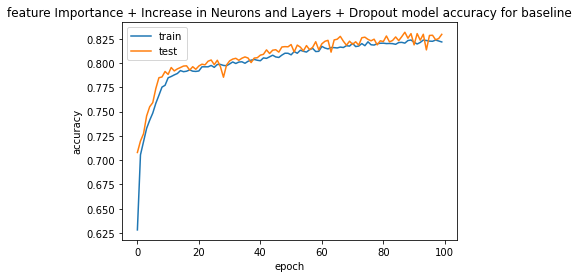

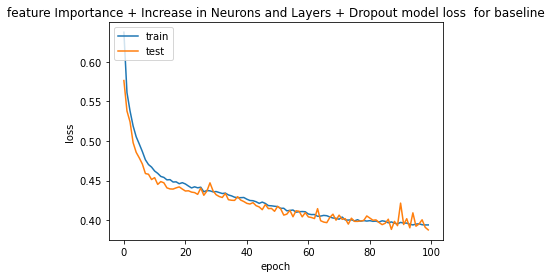

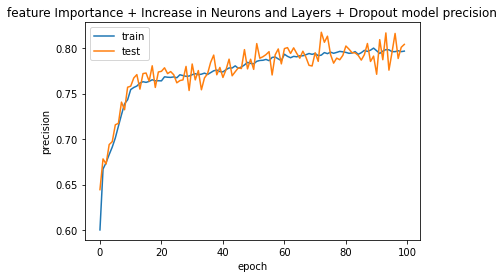

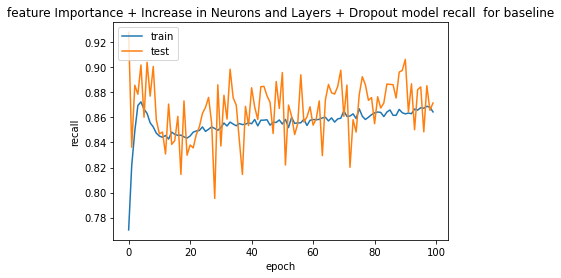

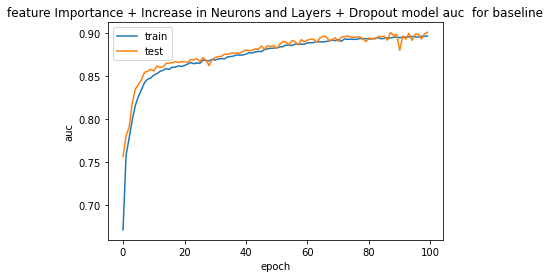

In [86]:
plotmodel(dropoutLayers_model,'feature Importance + Increase in Neurons and Layers + Dropout',plt)

In [88]:
printMetrics(dropoutLayers_model,'Dropout Regularized')

Dropout Regularized
Dropout Regularized Model loss: 42.72% (3.81%)
Dropout Regularized Model accuracy: 80.21% (2.80%)
Dropout Regularized Model precision: 77.41% (3.19%)
Dropout Regularized Model recall: 85.59% (1.15%)
Dropout Regularized Model auc: 87.35% (3.15%)
Dropout Regularized Model val_loss: 42.28% (3.13%)
Dropout Regularized Model val_accuracy: 80.76% (2.26%)
Dropout Regularized Model val_precision: 77.64% (2.95%)
Dropout Regularized Model val_recall: 86.70% (2.27%)
Dropout Regularized Model val_auc: 87.79% (2.40%)


In [112]:
def model_builder(hp):

    model1 = Sequential()
    
    hp_units = hp.Int('units', min_value=50, max_value=75, step=1)
    model1.add(Dense(input_dim=n_features,units=hp_units, activation='relu'))
    hp_units2 = hp.Int('units2', min_value=20, max_value=40, step=1)
    model1.add(Dense(units=hp_units2, activation='relu'))
    hp_units3 = hp.Int('units3', min_value=0, max_value=4, step=1)
    model1.add(Dense(units=hp_units3, activation='relu'))
    
    model1.add(Dense(1, activation='sigmoid'))


    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),loss='binary_crossentropy',metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
    return model

tuner = kt.Hyperband(model_builder, objective='val_accuracy',max_epochs=50,factor=10,overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# Perform hypertuning

tuner.search(feature_imp_x_scaled, Y, validation_split=0.3, epochs=50,callbacks=[stop_early])

Trial 20 Complete [00h 00m 17s]
val_accuracy: 0.8424999713897705

Best val_accuracy So Far: 0.8424999713897705
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit


In [113]:
best_hp = tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

hyperTunedModel = h_model.fit(feature_imp_x_scaled, Y, validation_split=0.3, epochs=100, batch_size=32, verbose=2)



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 70)                490       
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_41 (Dense)            (None, 35)                2485      
                                                                 
 dropout_1 (Dropout)         (None, 35)                0         
                                                                 
 dense_42 (Dense)            (None, 4)                 144       
                                                                 
 dense_43 (Dense)            (None, 1)                 5         
                                                                 
Total params: 3,124
Trainable params: 3,124
Non-train

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


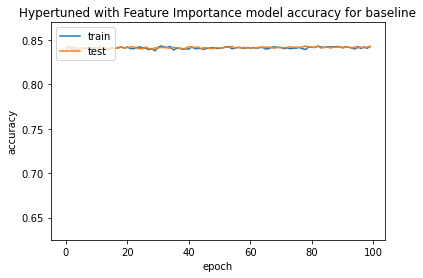

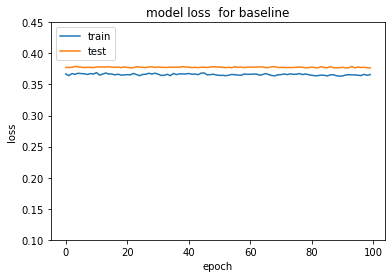

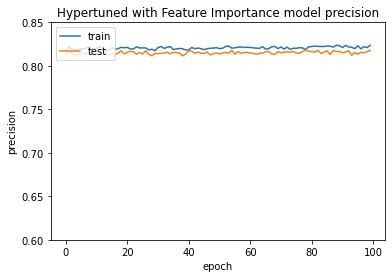

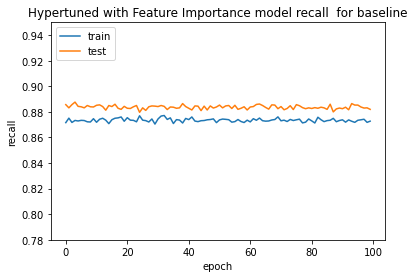

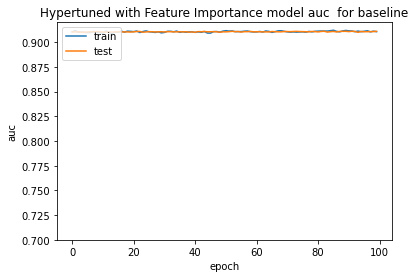

In [137]:
plotHyperModel(hyperTunedModel,'Hypertuned with Feature Importance',plt)

In [127]:
printMetrics(hyperTunedModel,'Hypertuned with Feature Importance')

Hypertuned with Feature Importance
Hypertuned with Feature Importance Model loss: 36.60% (0.12%)
Hypertuned with Feature Importance Model accuracy: 84.11% (0.11%)
Hypertuned with Feature Importance Model precision: 82.06% (0.14%)
Hypertuned with Feature Importance Model recall: 87.35% (0.14%)
Hypertuned with Feature Importance Model auc: 91.06% (0.06%)
Hypertuned with Feature Importance Model val_loss: 37.77% (0.06%)
Hypertuned with Feature Importance Model val_accuracy: 84.15% (0.07%)
Hypertuned with Feature Importance Model val_precision: 81.50% (0.15%)
Hypertuned with Feature Importance Model val_recall: 88.37% (0.15%)
Hypertuned with Feature Importance Model val_auc: 91.05% (0.02%)
